In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn

### 使用内置方法进行训练和评估
#本指南涵盖使用内置 API 进行训练和验证时的训练、评估和预测（推断）模型（例如 Model.fit()、Model.evaluate() 和 Model.predict()）。

In [ ]:
### 2.3.1 API 概述：第一个端到端示例
#将数据传递到模型的内置训练循环时，应当使用 NumPy 数组（如果数据很小且适合装入内存）或 tf.data Dataset 对象。
#   在接下来的段落中，我们将 MNIST 数据集用作 NumPy 数组，以演示如何使用优化器、损失和指标。

#我们考虑以下模型（在这里，我们使用函数式 API 构建了此模型，但它也可以是序贯模型或子类化模型）：
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
#下面是典型的端到端工作流，包括：
#   训练
#   根据从原始训练数据生成的预留集进行验证
#   对测试数据进行评估

#在此示例中，我们使用 MNIST 数据。
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
#我们指定训练配置（优化器、损失、指标）：
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
#我们调用 fit()，它会通过将数据切分成大小为 batch_size 的“批次”，然后在给定数量的 epochs 内重复遍历整个数据集来训练模型。
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)


In [ ]:
#返回的 history 对象保存训练期间的损失值和指标值记录：
history.history

In [ ]:
#我们通过 evaluate() 在测试数据上评估模型：
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

In [ ]:
#现在，我们来详细查看此工作流的每一部分。

In [8]:
### 2.3.2 compile() 方法：指定损失、指标和优化器
#为方便以后重用，我们将模型定义和编译步骤放入函数中；我们将在本指南的不同示例中多次调用它们。
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [ ]:
## 1.提供许多内置优化器、损失和指标
"""
通常，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：

SGD()（有或没有动量）
RMSprop()
Adam()
等等
损失：

MeanSquaredError()
KLDivergence()
CosineSimilarity()
等等
指标：

AUC()
Precision()
Recall()
等等
"""

In [ ]:
## 2.自定义损失
#如果您需要创建自定义损失，Keras 提供了两种方式。

#第一种方式涉及创建一个接受输入 y_true 和 y_pred 的函数。下面的示例显示了一个计算实际数据与预测值之间均方误差的损失函数：
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

In [ ]:
"""
如果您需要一个使用除 y_true 和 y_pred 之外的其他参数的损失函数，则可以将 tf.keras.losses.Loss 类子类化，并实现以下两种方法：

    __init__(self)：接受要在调用损失函数期间传递的参数
    call(self, y_true, y_pred)：使用目标 (y_true) 和模型预测 (y_pred) 来计算模型的损失
假设您要使用均方误差，但存在一个会抑制预测值远离 0.5（我们假设分类目标采用独热编码，且取值介于 0 和 1 之间）的附加项。这会为模型创建一个激励，
    使其不会对预测值过于自信，这可能有助于减轻过拟合（在尝试之前，我们不知道它是否有效！）。
"""

#您可以按以下方式处理：
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

In [ ]:
## 3.自定义指标
"""
如果您需要一个不属于 API 一部分的指标，则可以通过将 tf.keras.metrics.Metric 类子类化来轻松创建自定义指标。您需要实现 4 种方法：

__init__(self)，您将在其中为您的指标创建状态变量。
update_state(self, y_true, y_pred, sample_weight=None)，它使用目标 y_true 和模型预测 y_pred 来更新状态变量。
result(self)，它使用状态变量来计算最终结果。
reset_state(self)，它重新初始化指标的状态。
状态更新和结果计算是分开进行的（分别在 update_state() 和 result() 中），因为在某些情况下，结果计算的开销可能非常巨大并且只能定期进行。
"""

#下面以一个简单的示例展示了如何实现一个计算有多少样本被正确分类为属于给定类的 CategoricalTruePositives 指标：
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

In [ ]:
## 4.处理不适合标准签名的损失和指标
#参考：https://tensorflow.google.cn/guide/keras/train_and_evaluate?hl=zh-cn#%E5%A4%84%E7%90%86%E4%B8%8D%E9%80%82%E5%90%88%E6%A0%87%E5%87%86%E7%AD%BE%E5%90%8D%E7%9A%84%E6%8D%9F%E5%A4%B1%E5%92%8C%E6%8C%87%E6%A0%87

In [ ]:
## 5.自动分离验证预留集
#参数 validation_split 允许您自动保留部分训练数据以供验证。验证的计算方法是在进行任何打乱顺序之前，获取 fit() 调用接收到的数组的最后 x% 个样本。
#请注意，仅在使用 NumPy 数据进行训练时才能使用 validation_split。
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

In [ ]:
### 2.3.3 通过 tf.data 数据集进行训练和评估
#您可以将 Dataset 实例直接传递给方法 fit()、evaluate() 和 predict()：
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))


In [ ]:
#请注意，数据集会在每个周期结束时重置，因此可以在下一个周期重复使用。
#如果您只想在来自此数据集的特定数量批次上进行训练，则可以传递 steps_per_epoch 参数，此参数可以指定在继续下一个周期之前，模型应使用此数据集运行多少训练步骤。
#如果执行此操作，则不会在每个周期结束时重置数据集，而是会继续绘制接下来的批次。数据集最终将用尽数据（除非它是无限循环的数据集）。
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

In [ ]:
## 使用验证数据集
#您可以在 fit() 中将 Dataset 实例作为 validation_data 参数传递：
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

In [ ]:
#在每个周期结束时，模型将迭代验证数据集并计算验证损失和验证指标。

#如果只想对此数据集中的特定数量批次运行验证，则可以传递 validation_steps 参数，此参数可以指定在中断验证并进入下一个周期之前，模型应使用验证数据集运行多少个验证步骤：
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

#请注意，验证数据集将在每次使用后重置（这样您就可以在不同周期中始终根据相同的样本进行评估）。

#通过 Dataset 对象进行训练时，不支持参数 validation_split（从训练数据生成预留集），因为此功能需要为数据集样本编制索引的能力，而 Dataset API 通常无法做到这一点。

In [ ]:
### 2.3.4 使用样本加权和类加权
#在默认设置下，样本的权重由其在数据集中出现的频率决定。您可以通过两种方式独立于样本频率来加权数据：
#   类权重
#   样本权重

## 1.类权重
#通过将字典传递给 Model.fit() 的 class_weight 参数来进行设置。此字典
# 会将类索引映射到应当用于属于此类的样本的权重。
#这可用于在不重采样的情况下平衡类，或者用于训练更重视特定类的模型。

#下面是一个 NumPy 示例，我们在其中使用类权重或样本权重来提高对类 #5（MNIST 数据集中的数字“5”）进行正确分类的重要性。
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

In [ ]:
## 2.样本权重
"""
对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。
    通过 NumPy 数据进行训练时：将 sample_weight 参数传递给 Model.fit()。
    通过 tf.data 或任何其他类型的迭代器进行训练时：产生 (input_batch, label_batch, sample_weight_batch) 元组。

“样本权重”数组是一个由数字组成的数组，这些数字用于指定批次中每个样本在计算总损失时应当具有的权重。它通常用于不平衡的分类问题（理念是将更多权重分配给罕见类）。

当使用的权重为 1 和 0 时，此数组可用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。
"""
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)



In [ ]:
#下面是一个匹配的 Dataset 示例：
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

In [12]:
### 2.3.5 将数据传递到多输入、多输出模型  - 参考2.2.4节
#考虑以下模型，该模型具有形状为 (32, 32, 3) 的图像输入（即 (height, width, channels)）和形状为 (None, 10) 的时间序列输入（即 (timesteps, features)）。
#我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状为 (1,)）和在五个类上的概率分布（形状为 (5,)）。
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)


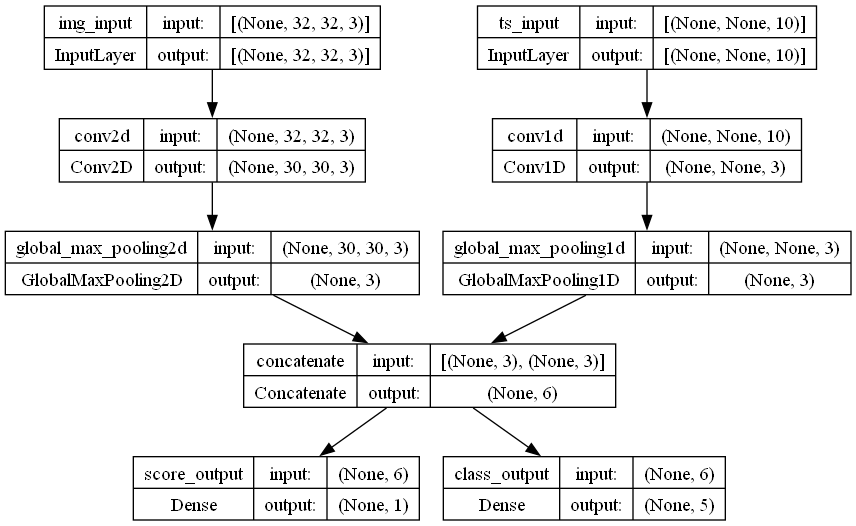

In [3]:
#我们来绘制这个模型，以便您可以清楚地看到我们在这里执行的操作（请注意，图中显示的形状是批次形状，而不是每个样本的形状）。
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
#在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

In [ ]:
#如果我们仅将单个损失函数传递给模型，则相同的损失函数将应用于每个输出（此处不合适）。

#对于指标同样如此：
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

In [ ]:
#由于我们已为输出层命名，我们还可以通过字典指定每个输出的损失和指标：
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

In [ ]:
#如果您的输出超过 2 个，我们建议使用显式名称和字典。

#可以使用 loss_weights 参数为特定于输出的不同损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过为类损失赋予 2 倍重要性来向“得分”损失赋予特权）：
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

In [ ]:
#如果这些输出用于预测而不是用于训练，也可以选择不计算某些输出的损失：
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

In [13]:
#将数据传递给 fit() 中的多输入或多输出模型的工作方式与在编译中指定损失函数的方式类似：
#   您可以传递 NumPy 数组的列表（1:1 映射到接收损失函数的输出），或者通过字典将输出名称映射到 NumPy 数组。
import numpy as np


model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)



4/4 [==============================] - 1s 7ms/step - loss: 4.3884 - score_output_loss: 0.1213 - class_output_loss: 4.2671


In [14]:
#下面是 Dataset 的用例：与我们对 NumPy 数组执行的操作类似，Dataset 应返回一个字典元组。
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 9ms/step - loss: 4.3571 - score_output_loss: 0.1124 - class_output_loss: 4.2447


In [ ]:
### 2.3.6 使用回调
"""
Keras 中的回调是在训练过程中的不同时间点（在某个周期开始时、在批次结束时、在某个周期结束时等）调用的对象。它们可用于实现特定行为，例如：
    在训练期间的不同时间点进行验证（除了内置的按周期验证外）
    定期或在超过一定准确率阈值时为模型设置检查点
    当训练似乎停滞不前时，更改模型的学习率
    当训练似乎停滞不前时，对顶层进行微调
    在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
    等等
"""
#回调可以作为列表传递给您对 fit() 的调用：

model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

In [ ]:
"""
Epoch 1/20
625/625 [==============================] - 3s 3ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9229
Epoch 2/20
625/625 [==============================] - 2s 2ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.1697 - val_sparse_categorical_accuracy: 0.9493
Epoch 3/20
625/625 [==============================] - 2s 2ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.1457 - val_sparse_categorical_accuracy: 0.9566
Epoch 4/20
625/625 [==============================] - 2s 2ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.1441 - val_sparse_categorical_accuracy: 0.9586
Epoch 5/20
625/625 [==============================] - 2s 2ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1432 - val_sparse_categorical_accuracy: 0.9596
Epoch 5: early stopping
<keras.callbacks.History at 0x7f5341a371c0>
"""

In [ ]:
## 1.提供多个内置回调
"""
Keras 中已经提供多个内置回调，例如：
    ModelCheckpoint：定期保存模型。
    EarlyStopping：当训练不再改善验证指标时，停止训练。
    TensorBoard：定期编写可在 TensorBoard 中可视化的模型日志（更多详细信息，请参阅“可视化”部分）。
    CSVLogger：将损失和指标数据流式传输到 CSV 文件。
    等等
"""


In [ ]:
## 2.编写您自己的回调
#您可以通过扩展基类 keras.callbacks.Callback 来创建自定义回调。回调可以通过类属性 self.model 访问其关联的模型。
#下面是一个简单的示例，在训练期间保存每个批次的损失值列表：
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        

In [ ]:
### 2.3.7 为模型设置检查点
#根据相对较大的数据集训练模型时，经常保存模型的检查点至关重要。

#实现此目标的最简单方式是使用 ModelCheckpoint 回调：
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

In [ ]:
#ModelCheckpoint 回调可用于实现容错：在训练随机中断的情况下，从模型的最后保存状态重新开始训练的能力。下面是一个基本示例：
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

In [ ]:
### 2.3.8 使用学习率时间表
#训练深度学习模型的常见模式是随着训练的进行逐渐减少学习。这通常称为“学习率衰减”。
#学习衰减时间表可以是静态的（根据当前周期或当前批次索引预先确定），也可以是动态的（响应模型的当前行为，尤其是验证损失）。

##1.将时间表传递给优化器
#通过将时间表对象作为优化器中的 learning_rate 参数传递，您可以轻松使用静态学习率衰减时间表：
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

#提供了几个内置时间表：ExponentialDecay、PiecewiseConstantDecay、PolynomialDecay 和 InverseTimeDecay。



In [ ]:
##2.使用回调实现动态学习率时间表
#由于优化器无法访问验证指标，因此无法使用这些时间表对象来实现动态学习率时间表（例如，当验证损失不再改善时降低学习率）。
#但是，回调确实可以访问所有指标，包括验证指标！因此，您可以通过使用可修改优化器上的当前学习率的回调来实现此模式。实际上，它甚至以 ReduceLROnPlateau 回调的形式内置。

In [ ]:
### 2.3.9 可视化训练期间的损失和指标
#在训练期间密切关注模型的最佳方式是使用 TensorBoard，这是一个基于浏览器的应用，它可以在本地运行，为您提供：
#   训练和评估的实时损失和指标图
#   （可选）层激活直方图的可视化
#   （可选）Embedding 层学习的嵌入向量空间的 3D 可视化

## 使用 TensorBoard 回调
#将 TensorBoard 与 Keras 模型和 fit 方法一起使用的最简单方式是 TensorBoard 回调。

#在最简单的情况下，只需指定您希望回调写入日志的位置即可：
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)